In [1]:
!pip install pandas numpy matplotlib seaborn jupyterlab

In [2]:
#3.1A  Individual Athlete Timeline

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import seaborn as sns
import os

In [4]:
# Load the dataset 
df = pd.read_csv('../raw/fivemetrics_data.csv')

In [5]:
# Define the target player names
target_players = ['PLAYER_741', 'PLAYER_555', 'PLAYER_755','PLAYER_995']

# Filter the original DataFrame
selected_players = df[df['playername'].isin(target_players)].copy()

In [10]:
# Imputing values that are incorrectly recorded (below realistic thresholds)

# Define thresholds by metric and gender group
thresholds = {
    'Jump Height(M)': {'Women': 0.3, 'Men': 0.4},
    'Peak Propulsive Power(W)': {'Women': 3200, 'Men': 4500},
    'Peak Velocity(M/S)': {'Women': 2.4, 'Men': 2.8},
    'Speed_Max': {'Women': 5.0, 'Men': 6.0},
    'Distance_Total': {'Women': 1000, 'Men': 1000}  # fallback threshold
}

metrics = list(thresholds.keys())

for metric in metrics:
    metric_mask = selected_players['metric'] == metric
    
    # Step 1: Ensure values are float type
    selected_players.loc[metric_mask, 'value'] = selected_players.loc[metric_mask, 'value'].astype(float)
    
    # Step 2: Replace values below threshold with NaN, based on team group (Men/Women)
    def apply_threshold(row):
        tg = str(row['groupteam']).lower()  # normalize to lowercase
        if "women" in tg:
            cutoff = thresholds[metric]['Women']
        elif "men" in tg:
            cutoff = thresholds[metric]['Men']
        else:
            cutoff = None  # skip if group not identified
        
        if cutoff is not None and row['value'] < cutoff:
            return np.nan
        return row['value']
    
    selected_players.loc[metric_mask, 'value'] = selected_players.loc[metric_mask].apply(apply_threshold, axis=1)
    
    # Step 3: Interpolate missing values linearly (within metric group)
    selected_players.loc[metric_mask, 'value'] = selected_players.loc[metric_mask, 'value'].interpolate(method='linear')
    
    # Step 4: Fill remaining NaNs with backfill/forward fill
    selected_players.loc[metric_mask, 'value'] = (
        selected_players.loc[metric_mask, 'value']
        .bfill()
        .ffill()
    )

# Final cleanup: ensure numeric values and valid timestamps
selected_players['value'] = selected_players['value'].astype(float)
selected_players['timestamp'] = pd.to_datetime(selected_players['timestamp'], errors='coerce')

In [11]:
selected_players

,id,playername,timestamp,device,metric,value,team,sportsteam,groupteam
74775,5413352,PLAYER_755,2024-12-19 19:00:29,kinexon,Distance_Total,3135.249752,Mens Basketball,Basketball,Men's Basketball
74776,5413413,PLAYER_755,2024-12-19 19:00:29,kinexon,Speed_Max,6.197649,Mens Basketball,Basketball,Men's Basketball
74781,5413601,PLAYER_995,2024-12-19 19:00:29,kinexon,Distance_Total,2209.935210,Mens Basketball,Basketball,Men's Basketball
74782,5413662,PLAYER_995,2024-12-19 19:00:29,kinexon,Speed_Max,6.269871,Mens Basketball,Basketball,Men's Basketball
74799,5414311,PLAYER_555,2024-12-20 14:20:00,kinexon,Distance_Total,5285.852960,Womens Basketball,Basketball,Women's Basketball
...,...,...,...,...,...,...,...,...,...
88832,6599767,PLAYER_555,2025-10-19 15:25:00,kinexon,Speed_Max,6.096703,Womens Basketball,Basketball,Women's Basketball
88960,6613376,PLAYER_755,2025-10-20 18:31:00,kinexon,Distance_Total,5753.349620,Mens Basketball,Basketball,Men's Basketball
88961,6613437,PLAYER_755,2025-10-20 18:31:00,kinexon,Speed_Max,6.015481,Mens Basketball,Basketball,Men's Basketball
88966,6613622,PLAYER_995,2025-10-20 18:31:00,kinexon,Distance_Total,5125.220385,Mens Basketball,Basketball,Men's Basketball


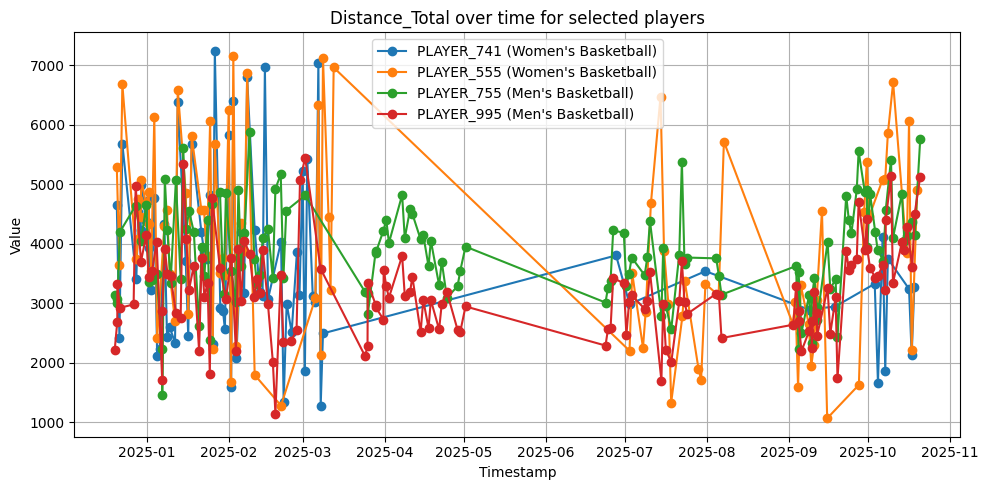

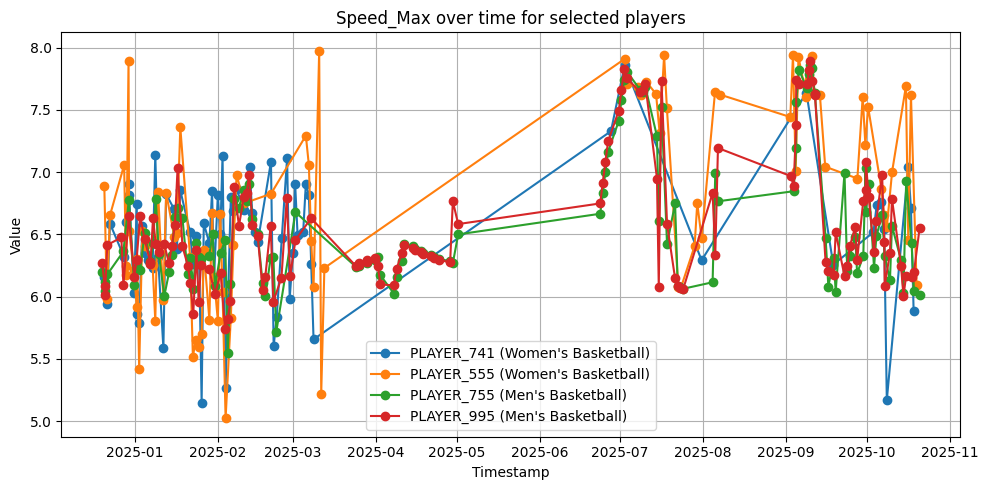

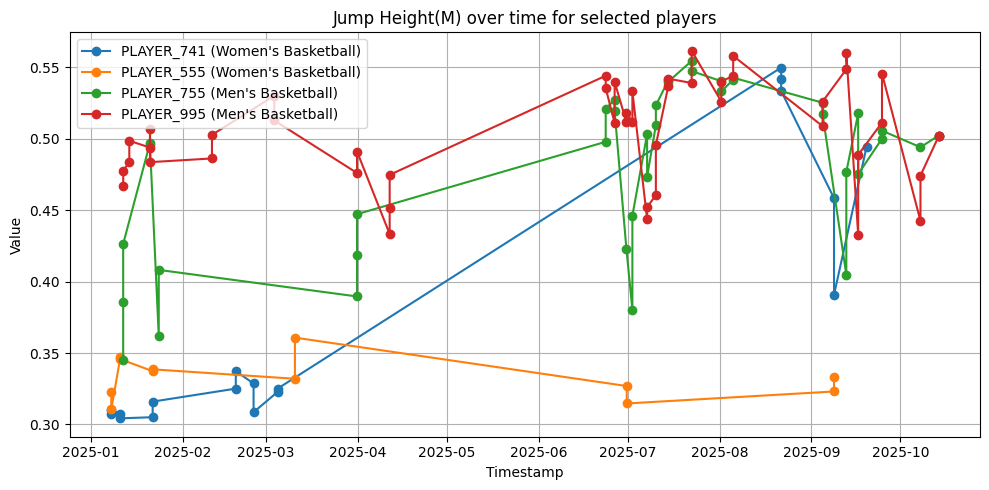

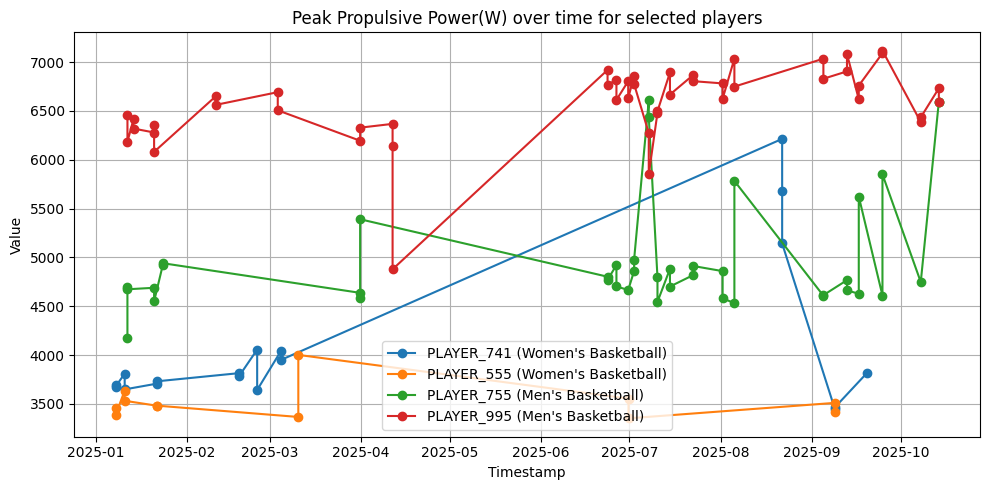

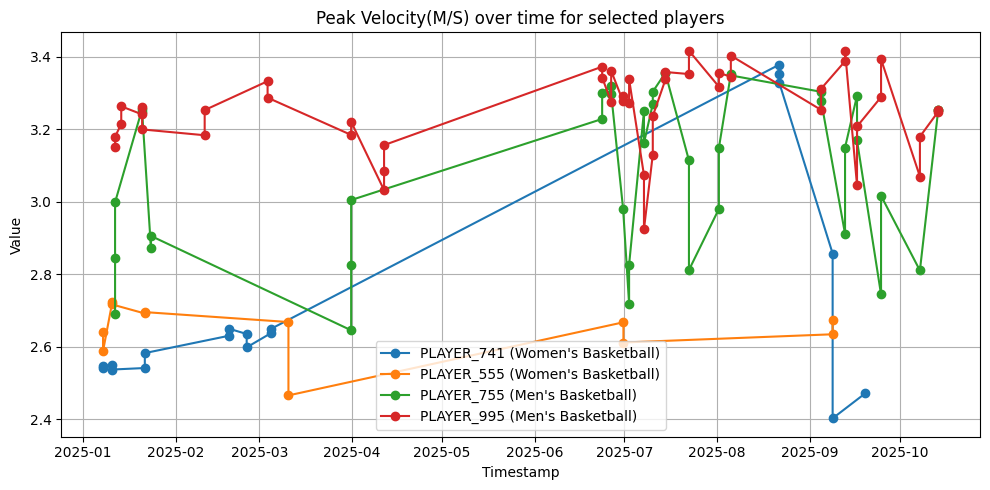

In [13]:
# All 4 players' data visualization

# Convert 'timestamp' column to datetime and drop invalid entries
selected_players['timestamp'] = pd.to_datetime(selected_players['timestamp'], errors='coerce')
selected_players = selected_players.dropna(subset=['timestamp'])

# Filter dataset to include only records from the past year
current_date = pd.Timestamp.today()
cutoff_date = current_date - pd.DateOffset(years=1)
selected_players = selected_players[selected_players['timestamp'] >= cutoff_date]

# Identify all unique metrics in the dataset
metrics = selected_players['metric'].unique()

# Plot each metric across all selected players
for metric in metrics:
    metric_df = selected_players[selected_players['metric'] == metric]
    plt.figure(figsize=(10, 5))

    # Plot each player's data for this metric
    for player in target_players:
        player_df = metric_df[metric_df['playername'] == player]

        # Retrieve team name (assumes consistency per player in this subset)
        team_name = player_df['groupteam'].iloc[0] if not player_df.empty else "Unknown"

        # Plot player values over time, labeled with player and team
        plt.plot(player_df['timestamp'], player_df['value'], marker='o', label=f"{player} ({team_name})")

    # Customize chart appearance
    plt.title(f"{metric} over time for selected players")
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [17]:
#SINGLE PLAYER VISUALIZATION

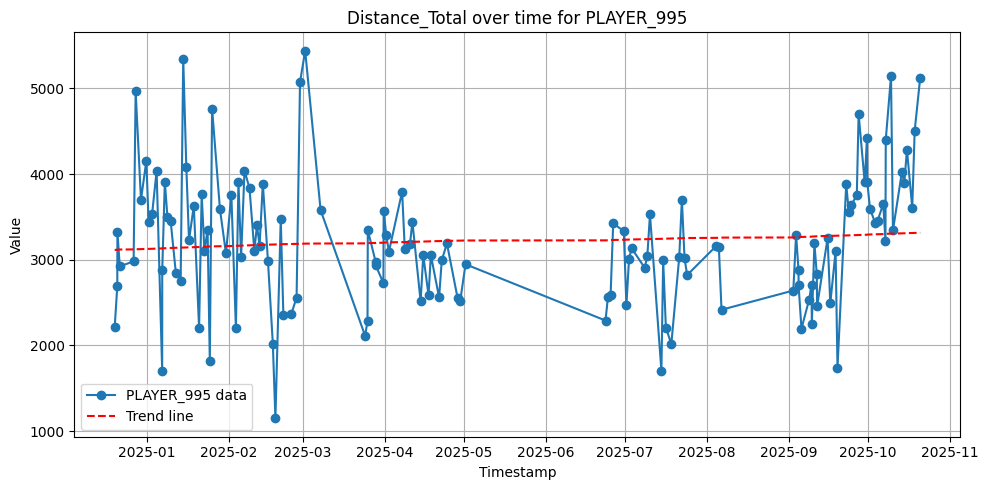

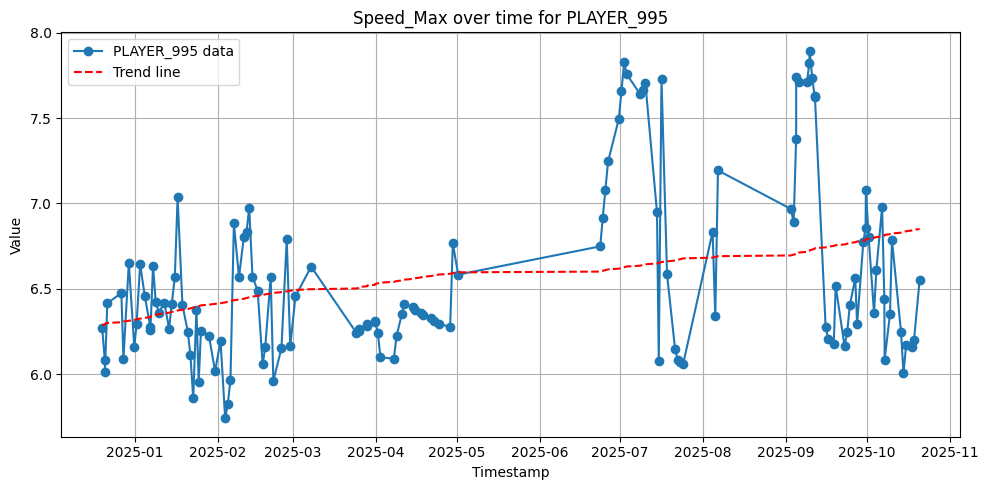

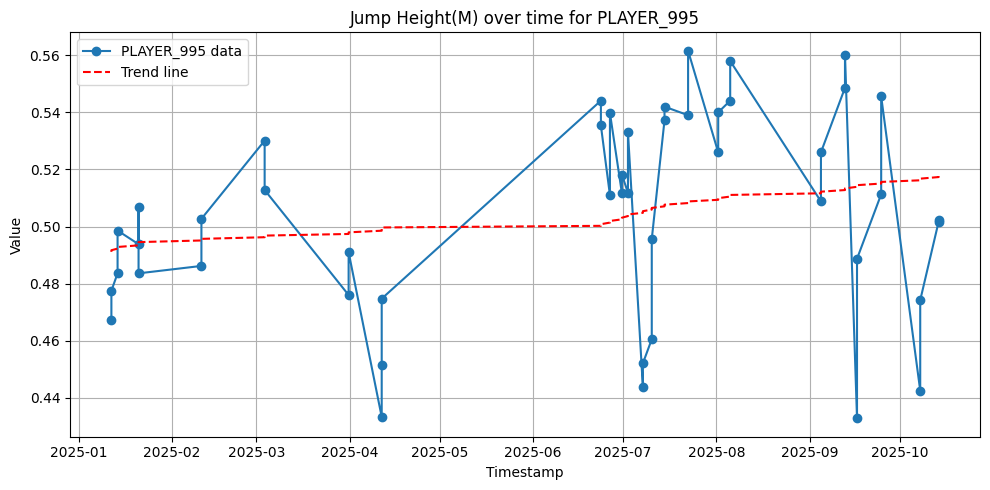

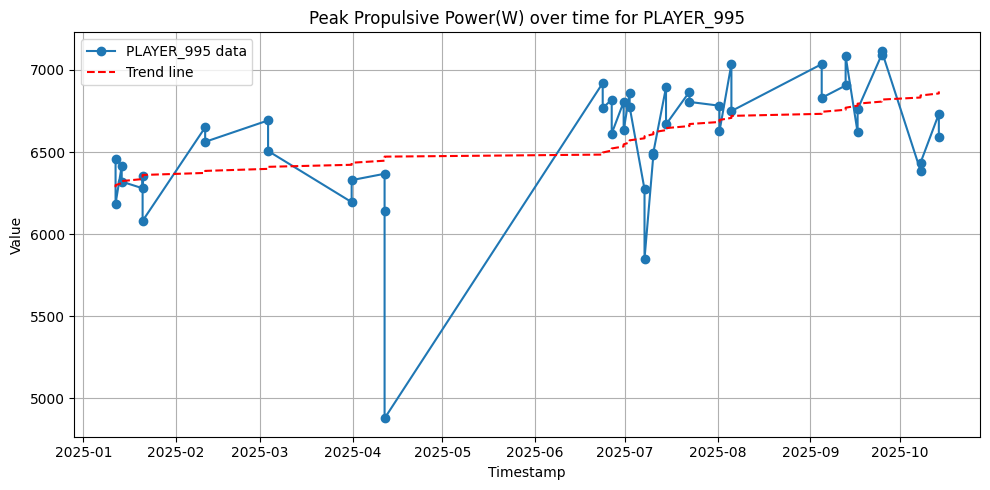

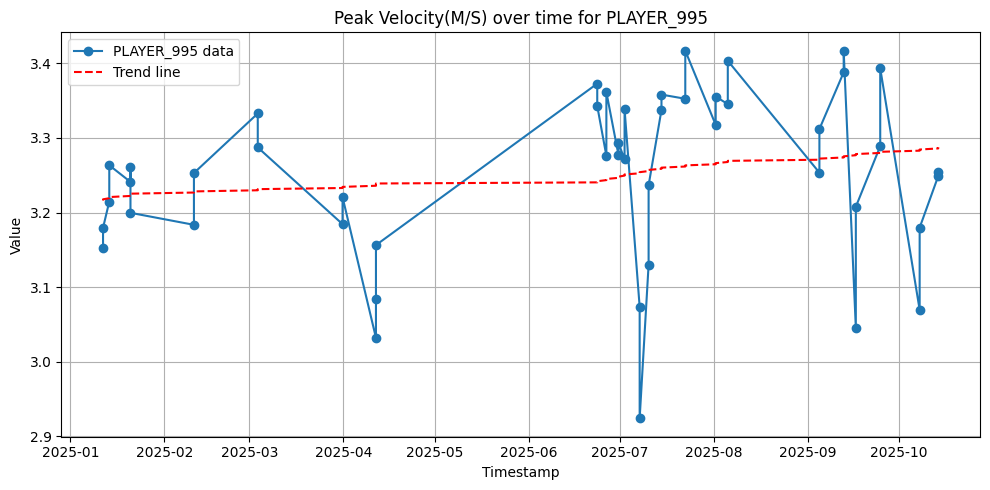

In [14]:
# Filter for a single player (example: PLAYER_995)
player_id = 'PLAYER_995'  # Change player ID to analyze different players

# Ensure 'timestamp' column is in datetime format
selected_players['timestamp'] = pd.to_datetime(selected_players['timestamp'])

# Subset dataset for the chosen player
player_df = selected_players[selected_players['playername'] == player_id]

# Restrict data to the last 12 months (relative to most recent test date)
cutoff_date = player_df['timestamp'].max() - pd.DateOffset(months=12)
player_df = player_df[player_df['timestamp'] >= cutoff_date]

# Identify all unique metrics recorded for this player
metrics = player_df['metric'].unique()

# Plot each metric for the selected player
for metric in metrics:
    metric_df = player_df[player_df['metric'] == metric]

    # Prepare x (index of tests) and y (metric values)
    x = np.arange(len(metric_df['timestamp']))
    y = metric_df['value'].values

    # Fit linear regression (trend line) if enough data points exist
    if len(x) > 1:
        coeffs = np.polyfit(x, y, 1)
        trend = np.poly1d(coeffs)

    # Plot metric values over time
    plt.figure(figsize=(10, 5))
    plt.plot(metric_df['timestamp'], y, marker='o', label=f"{player_id} data")

    # Add regression trend line
    if len(x) > 1:
        plt.plot(metric_df['timestamp'], trend(x), color='red', linestyle='--', label="Trend line")

    # Customize chart appearance
    plt.title(f"{metric} over time for {player_id}")
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
## 3.1B Identify best and worst performance dates

# Ensure 'timestamp' column is datetime and drop invalid entries
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp', 'value'])

# Find best performance date (highest value per metric)
best_dates = (
    player_df.loc[player_df.groupby('metric')['value'].idxmax()]
    [['metric', 'value', 'timestamp']]
    .rename(columns={'value': 'best_value', 'timestamp': 'best_date'})
)

# Find worst performance date (lowest value per metric)
worst_dates = (
    player_df.loc[player_df.groupby('metric')['value'].idxmin()]
    [['metric', 'value', 'timestamp']]
    .rename(columns={'value': 'worst_value', 'timestamp': 'worst_date'})
)

# Merge best and worst into one summary table
performance_summary = pd.merge(best_dates, worst_dates, on='metric')

# Display results sorted by metric
print(f"Best and worst performance dates for {player_df['playername'].iloc[0]}:")
print(performance_summary.sort_values(by='metric'))

Best and worst performance dates for PLAYER_995:
                     metric   best_value           best_date  worst_value  \
0            Distance_Total  5440.675330 2025-03-01 22:05:36  1148.556710   
1            Jump Height(M)     0.561600 2025-07-22 14:28:44     0.432800   
2  Peak Propulsive Power(W)  7117.444600 2025-09-24 19:49:19  4878.451700   
3        Peak Velocity(M/S)     3.416800 2025-07-22 14:28:44     2.924200   
4                 Speed_Max     7.894569 2025-09-09 17:45:00     5.741233   

           worst_date  
0 2025-02-18 15:30:52  
1 2025-09-16 18:56:01  
2 2025-04-11 16:45:14  
3 2025-07-07 13:43:55  
4 2025-02-03 16:30:56  


In [16]:
## 3.1B Identify best and worst performance dates for selected players

# Ensure 'timestamp' column is datetime and drop invalid entries
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp', 'value'])

# Filter dataset for chosen players
player_df = df[df['playername'].isin(target_players)]

# Find best performance date (highest value per player + metric)
best_dates = (
    player_df.loc[player_df.groupby(['playername', 'metric'])['value'].idxmax()]
    [['playername', 'metric', 'value', 'timestamp']]
    .rename(columns={'value': 'best_value', 'timestamp': 'best_date'})
)

# Find worst performance date (lowest value per player + metric)
worst_dates = (
    player_df.loc[player_df.groupby(['playername', 'metric'])['value'].idxmin()]
    [['playername', 'metric', 'value', 'timestamp']]
    .rename(columns={'value': 'worst_value', 'timestamp': 'worst_date'})
)

# Merge best and worst into one summary table
performance_summary = pd.merge(best_dates, worst_dates, on=['playername', 'metric'])

# Display results for each player separately
for player in target_players:
    print(f"\nBest and worst performance dates for {player}:")
    print(performance_summary[performance_summary['playername'] == player].sort_values(by='metric'))


Best and worst performance dates for PLAYER_741:
   playername                    metric   best_value           best_date  \
5  PLAYER_741            Distance_Total  7241.551149 2025-01-26 16:55:00   
6  PLAYER_741            Jump Height(M)     0.385100 2024-02-26 17:37:45   
7  PLAYER_741  Peak Propulsive Power(W)  4554.847800 2024-02-26 17:37:45   
8  PLAYER_741        Peak Velocity(M/S)     2.902500 2024-02-26 17:37:45   
9  PLAYER_741                 Speed_Max     7.455508 2024-11-21 14:30:06   

   worst_value          worst_date  
5     0.069524 2025-07-02 17:20:00  
6     0.084100 2023-07-27 16:38:19  
7  1755.289700 2022-06-16 15:59:55  
8     1.531500 2023-07-27 16:38:19  
9     0.068057 2025-07-02 17:20:00  

Best and worst performance dates for PLAYER_555:
   playername                    metric   best_value           best_date  \
0  PLAYER_555            Distance_Total  8259.075417 2024-12-01 19:45:03   
1  PLAYER_555            Jump Height(M)     0.369600 2023-07-18 16:26

In [17]:
# 3.1C Calculate improvement or decline trends over the last 12 months for each metric

# Select player of interest
player_name = 'PLAYER_995'  # Change to desired player
player_df = selected_players[selected_players['playername'] == player_name]

# Identify all unique metrics for this player
metrics_player = player_df['metric'].unique()

# Prepare list to store trend results
trend_results = []

# Loop through each metric and calculate trend
for metric in metrics_player:
    metric_df = player_df[player_df['metric'] == metric]
    
    # Only proceed if there are at least 2 data points
    if len(metric_df) >= 2:
        # Convert timestamps to ordinal values for regression
        x = metric_df['timestamp'].map(pd.Timestamp.toordinal)
        y = metric_df['value']
        
        # Perform linear regression on time vs metric values
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        
        # Classify trend direction based on slope
        trend = 'improving' if slope > 0 else 'declining' if slope < 0 else 'stable'
        
        # Append results to list
        trend_results.append({
            'metric': metric,
            'slope': slope,
            'trend': trend,
            'p_value': p_value
        })

# Convert results to DataFrame for summary
trend_df = pd.DataFrame(trend_results)

# Display trend summary sorted by metric
print(f"\nTrend analysis for {player_name} over the last 12 months:")
print(trend_df.sort_values(by='metric'))


Trend analysis for PLAYER_995 over the last 12 months:
                     metric     slope      trend   p_value
0            Distance_Total  0.418588  improving  0.527951
2            Jump Height(M)  0.000102  improving  0.076254
3  Peak Propulsive Power(W)  2.109274  improving  0.000373
4        Peak Velocity(M/S)  0.000262  improving  0.150508
1                 Speed_Max  0.001902  improving  0.000008


In [18]:
#MULTIPLE PLAYER VISUALIZATION

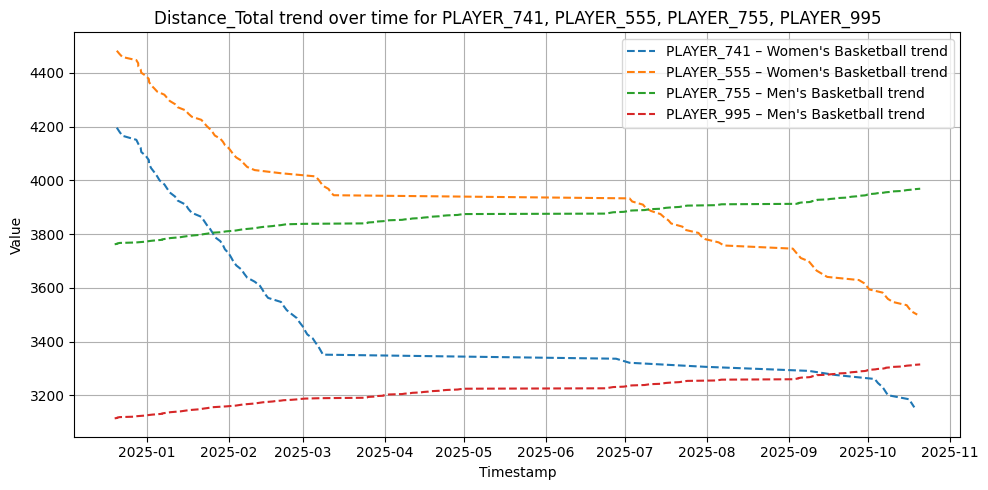

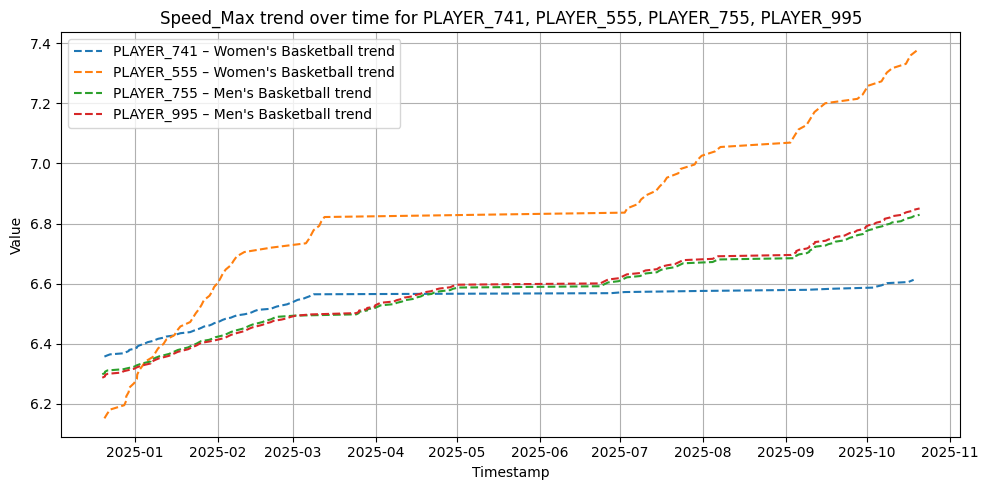

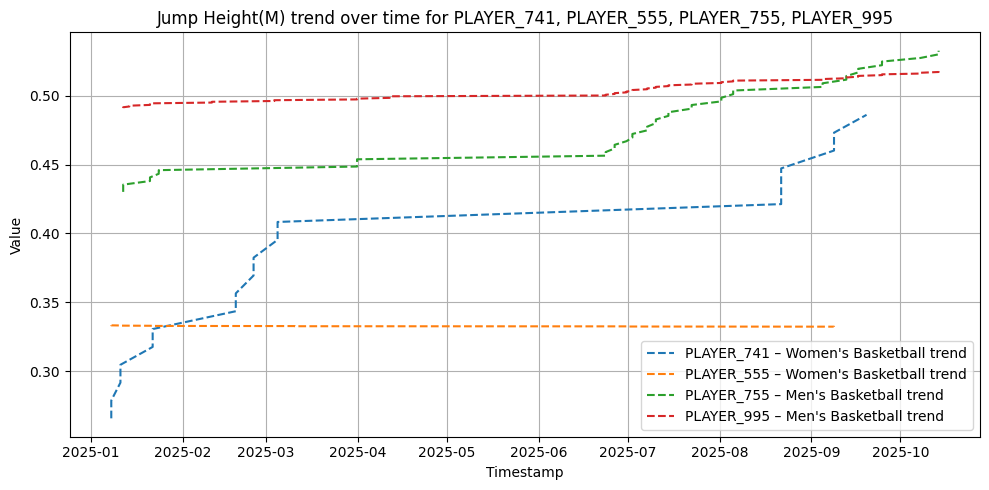

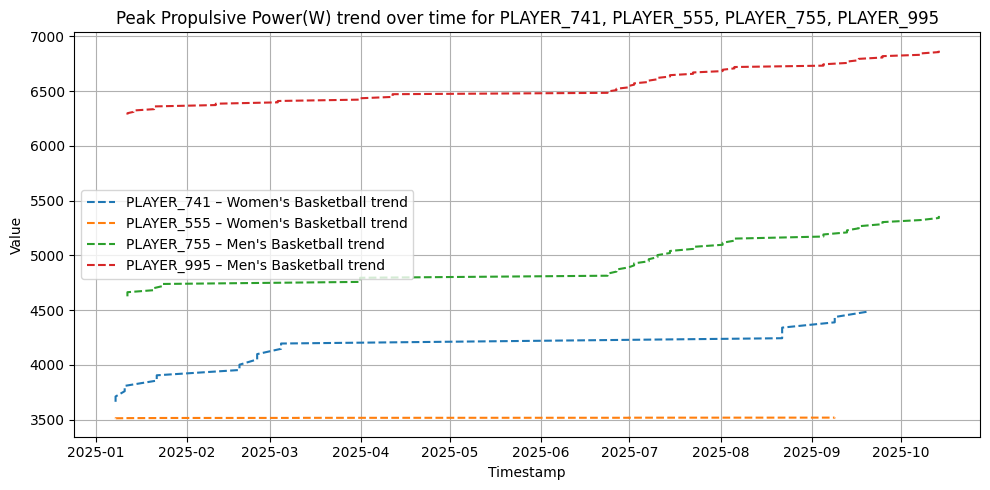

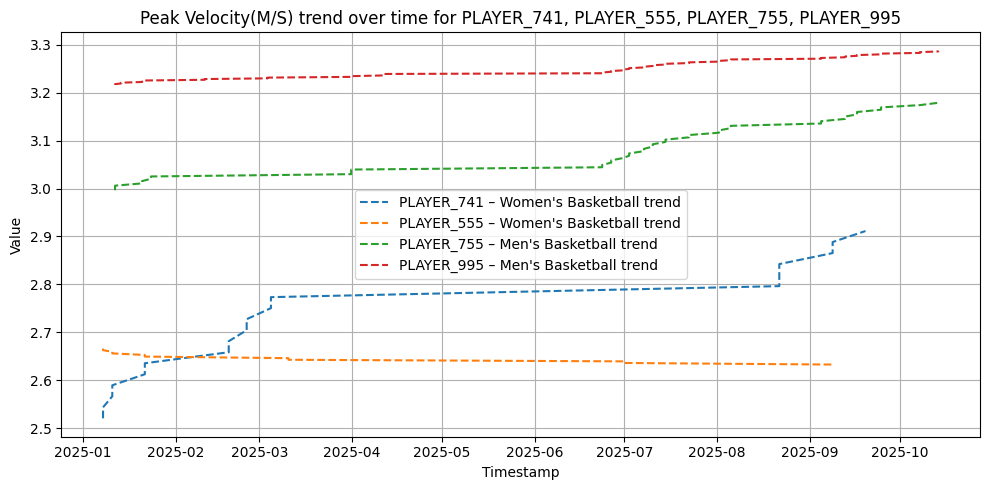

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure 'timestamp' column is in datetime format
selected_players['timestamp'] = pd.to_datetime(selected_players['timestamp'])

# Filter dataset for chosen players
player_df = selected_players[selected_players['playername'].isin(target_players)]

# Restrict data to the last 12 months (relative to most recent test date)
cutoff_date = player_df['timestamp'].max() - pd.DateOffset(months=12)
player_df = player_df[player_df['timestamp'] >= cutoff_date]

# Identify all unique metrics recorded for these players
metrics = player_df['metric'].unique()

# Plot each metric for all target players
for metric in metrics:
    metric_df = player_df[player_df['metric'] == metric]

    plt.figure(figsize=(10, 5))

    # Loop through each player in target_players
    for player in target_players:
        p_df = metric_df[metric_df['playername'] == player]
        x = np.arange(len(p_df['timestamp']))
        y = p_df['value'].values

        # Get the groupteam for this player (take first non-null value)
        if not p_df.empty:
            groupteam = p_df['groupteam'].iloc[0]
        else:
            groupteam = "Unknown Team"

        # Fit linear regression (trend line) if enough data points exist
        if len(x) > 1:
            coeffs = np.polyfit(x, y, 1)
            trend = np.poly1d(coeffs)

            # Plot regression trend line only (no raw data points)
            plt.plot(
                p_df['timestamp'],
                trend(x),
                linestyle='--',
                label=f"{player} – {groupteam} trend"
            )

    # Customize chart appearance
    plt.title(f"{metric} trend over time for {', '.join(target_players)}")
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [19]:
# 3.1C Calculate improvement or decline trends over the last 12 months for each player and metric

from scipy.stats import linregress
import pandas as pd

# Ensure 'timestamp' column is datetime and drop invalid entries
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp', 'value'])

# Filter dataset for chosen players
selected_players = df[df['playername'].isin(target_players)]

# Restrict data to the last 12 months (relative to current date)
cutoff_date = pd.Timestamp.now() - pd.DateOffset(months=12)
selected_players = selected_players[selected_players['timestamp'] >= cutoff_date]

# Prepare list to store trend results
trend_results = []

# Loop through each player
for player_name in target_players:
    player_df = selected_players[selected_players['playername'] == player_name]
    metrics_player = player_df['metric'].unique()

    # Loop through each metric for the player
    for metric in metrics_player:
        metric_df = player_df[player_df['metric'] == metric]

        # Only proceed if there are at least 2 data points
        if len(metric_df) >= 2:
            # Convert timestamps to ordinal values for regression
            x = metric_df['timestamp'].map(pd.Timestamp.toordinal)
            y = metric_df['value']

            # Perform linear regression on time vs metric values
            slope, intercept, r_value, p_value, std_err = linregress(x, y)

            # Classify trend direction based on slope
            trend = 'improving' if slope > 0 else 'declining' if slope < 0 else 'stable'

            # Append results to list
            trend_results.append({
                'playername': player_name,
                'metric': metric,
                'slope': slope,
                'trend': trend,
                'p_value': p_value
            })

# Convert results to DataFrame for summary
trend_df = pd.DataFrame(trend_results)

# Display trend summary for each player separately
for player_name in target_players:
    print(f"\nTrend analysis for {player_name} over the last 12 months:")
    print(trend_df[trend_df['playername'] == player_name].sort_values(by='metric'))


Trend analysis for PLAYER_741 over the last 12 months:
   playername                    metric     slope      trend       p_value
0  PLAYER_741            Distance_Total -6.972684  declining  1.589283e-03
2  PLAYER_741            Jump Height(M) -0.000544  declining  1.095650e-04
3  PLAYER_741  Peak Propulsive Power(W) -2.862907  declining  5.532695e-03
4  PLAYER_741        Peak Velocity(M/S) -0.002001  declining  6.086197e-04
1  PLAYER_741                 Speed_Max -0.010972  declining  2.033820e-07

Trend analysis for PLAYER_555 over the last 12 months:
   playername                    metric     slope      trend   p_value
5  PLAYER_555            Distance_Total -2.101610  declining  0.207961
7  PLAYER_555            Jump Height(M) -0.000027  declining  0.642269
8  PLAYER_555  Peak Propulsive Power(W) -0.058731  declining  0.905675
9  PLAYER_555        Peak Velocity(M/S) -0.000080  declining  0.729550
6  PLAYER_555                 Speed_Max  0.004382  improving  0.000989

Trend analy

In [20]:
#save to CSV
selected_players.to_csv('../raw/selected_players_data.csv', index=False)


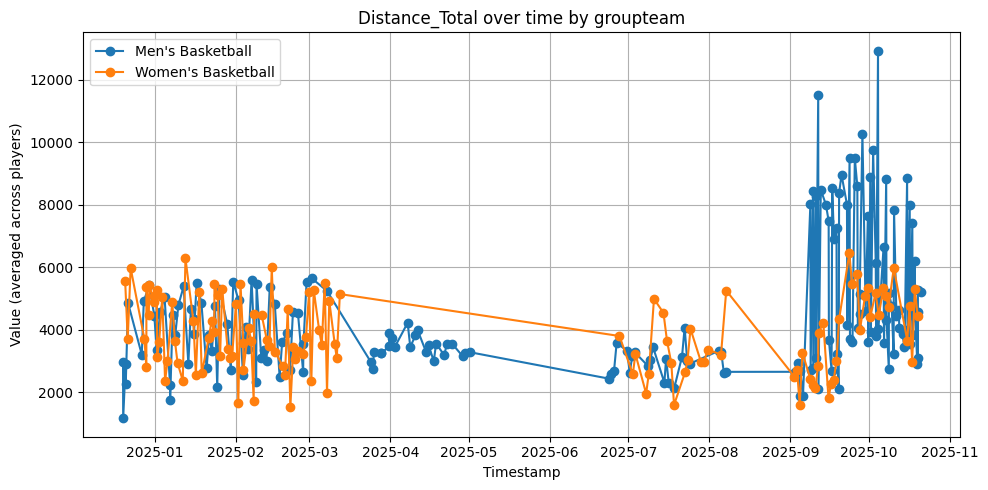

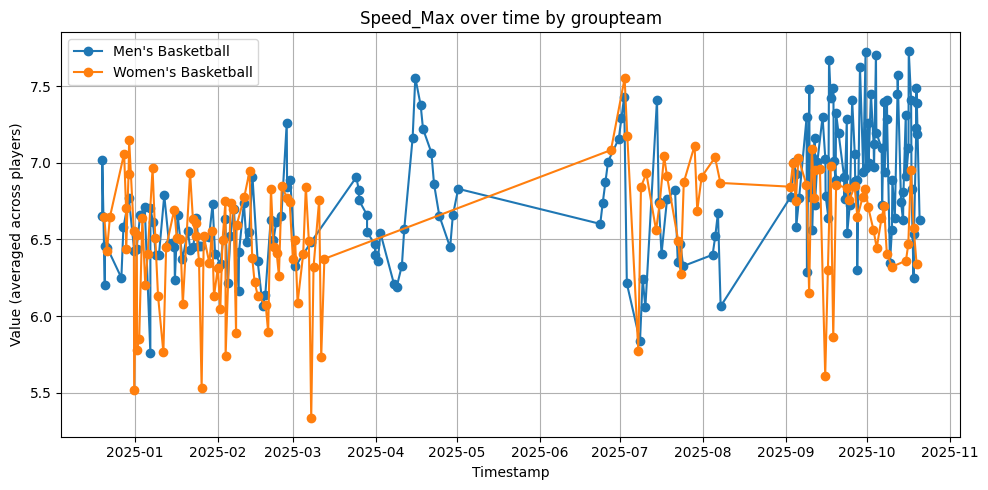

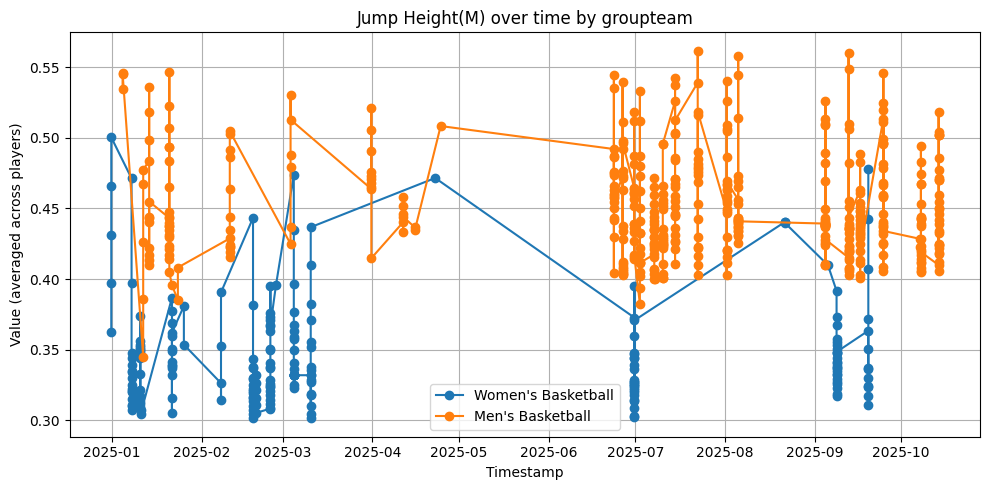

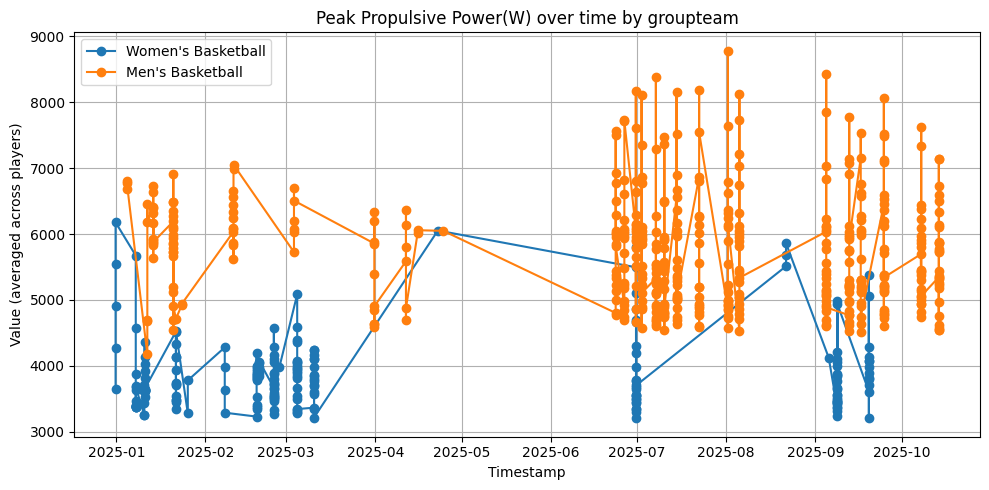

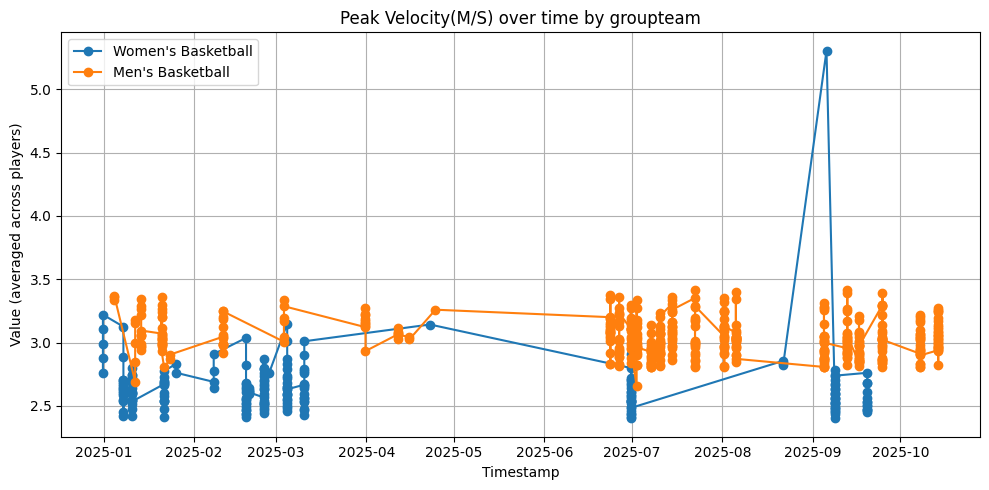

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('../raw/fivemetrics_data.csv')

# Keep only Men's and Women's Basketball teams
players_df = df[df['groupteam'].isin(["Men's Basketball", "Women's Basketball"])].copy()

thresholds = {
    'Jump Height(M)': {'Women': 0.3, 'Men': 0.4},
    'Peak Propulsive Power(W)': {'Women': 3200, 'Men': 4500},
    'Peak Velocity(M/S)': {'Women': 2.4, 'Men': 2.8},
    'Speed_Max': {'Women': 5.0, 'Men': 6.0},
    'Distance_Total': {'Women': 1000, 'Men': 1000}
}

metrics = list(thresholds.keys())

for metric in metrics:
    metric_mask = players_df['metric'] == metric
    players_df.loc[metric_mask, 'value'] = players_df.loc[metric_mask, 'value'].astype(float)

    def apply_threshold(row):
        tg = str(row['groupteam']).lower()
        if "women" in tg:
            cutoff = thresholds[metric]['Women']
        elif "men" in tg:
            cutoff = thresholds[metric]['Men']
        else:
            cutoff = None
        if cutoff is not None and row['value'] < cutoff:
            return np.nan
        return row['value']

    players_df.loc[metric_mask, 'value'] = players_df.loc[metric_mask].apply(apply_threshold, axis=1)
    players_df.loc[metric_mask, 'value'] = players_df.loc[metric_mask, 'value'].interpolate(method='linear')
    players_df.loc[metric_mask, 'value'] = (
        players_df.loc[metric_mask, 'value']
        .bfill()
        .ffill()
    )

players_df['value'] = players_df['value'].astype(float)
players_df['timestamp'] = pd.to_datetime(players_df['timestamp'], errors='coerce')
players_df = players_df.dropna(subset=['timestamp'])

current_date = pd.Timestamp.today()
cutoff_date = current_date - pd.DateOffset(years=1)
players_df = players_df[players_df['timestamp'] >= cutoff_date]

metrics = players_df['metric'].unique()

for metric in metrics:
    metric_df = players_df[players_df['metric'] == metric]
    plt.figure(figsize=(10, 5))

    grouped = (
        metric_df.groupby(['timestamp', 'groupteam'])['value']
        .mean()
        .reset_index()
    )

    for team in grouped['groupteam'].unique():
        team_df = grouped[grouped['groupteam'] == team]
        plt.plot(team_df['timestamp'], team_df['value'], marker='o', label=team)

    plt.title(f"{metric} over time by groupteam")
    plt.xlabel("Timestamp")
    plt.ylabel("Value (averaged across players)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()